In [54]:
m = 2251262568%20 +1
print(m)

9


In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [56]:
df = pd.read_csv('/content/AirPassengers.csv')
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [58]:
df['Month'] = pd.to_datetime(df['Month'])
df

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


In [59]:
full_range = pd.date_range(start=df['Month'].min(), end=df['Month'].max(), freq='MS')

# Tìm các mốc thời gian bị thiếu
missing_dates = full_range.difference(df['Month'])

# In ra các tháng bị thiếu (nếu có)
if not missing_dates.empty:
    print("Các mốc thời gian bị thiếu:")
    print(missing_dates)
else:
    print("Không có mốc thời gian nào bị thiếu.")

Không có mốc thời gian nào bị thiếu.


# Kiểm tra tính dừng

In [60]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['#Passengers'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")


ADF Statistic: 0.8153688792060498
p-value: 0.991880243437641


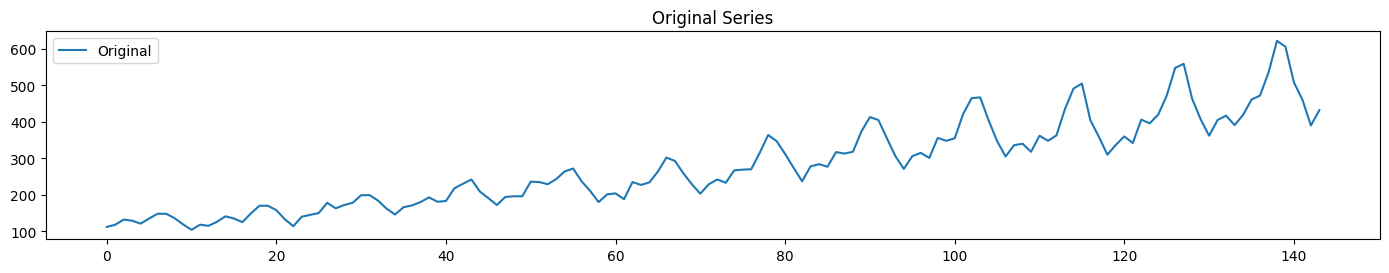

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))

plt.subplot(4, 1, 1)
plt.plot(df['#Passengers'], label='Original')
plt.title('Original Series')
plt.legend()

plt.tight_layout()
plt.show()


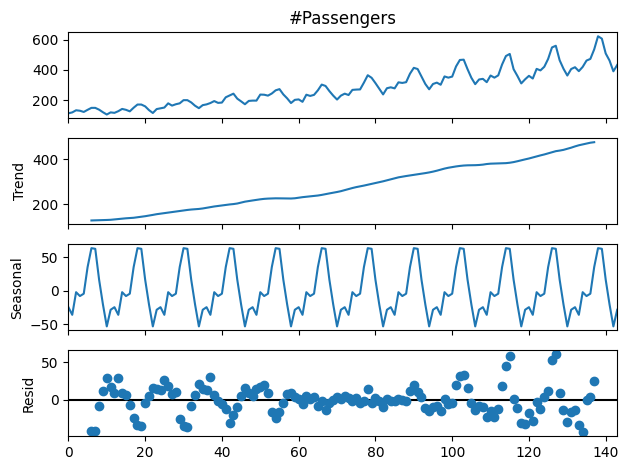

In [62]:
dec = sm.tsa.seasonal_decompose(df['#Passengers'], period=12).plot()
plt.show()

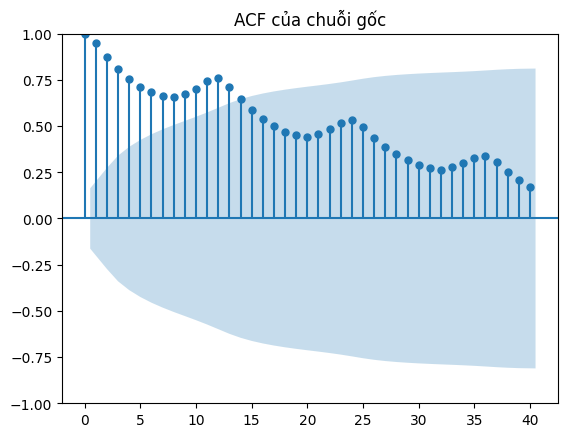

In [63]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df['#Passengers'], lags=40)
plt.title('ACF của chuỗi gốc')
plt.show()

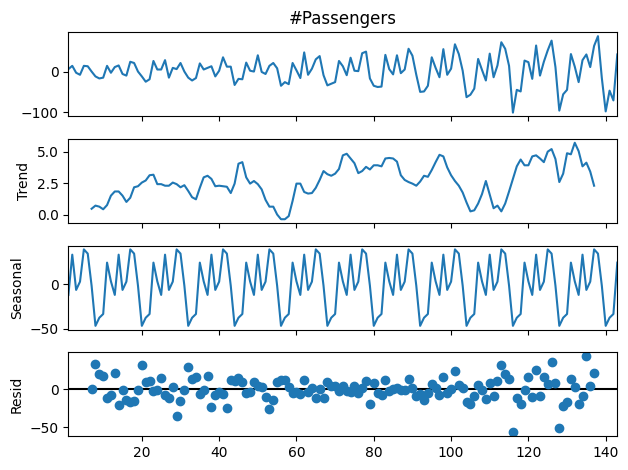

In [64]:
data_diff = df['#Passengers'].diff().dropna()

dec = sm.tsa.seasonal_decompose(data_diff, period=12).plot()
plt.show()

In [65]:
result = adfuller(data_diff)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -2.8292668241700047
p-value: 0.05421329028382478


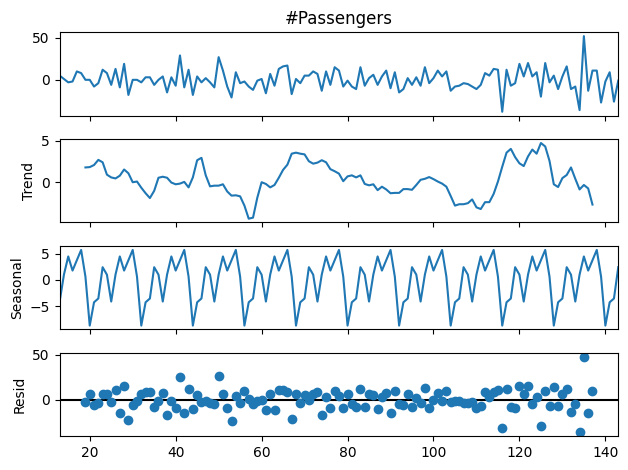

In [66]:
data_diff_seas = data_diff.diff(12)
data_diff_seas = data_diff_seas.dropna()
dec = sm.tsa.seasonal_decompose(data_diff_seas,period = 12)
dec.plot()
plt.show()

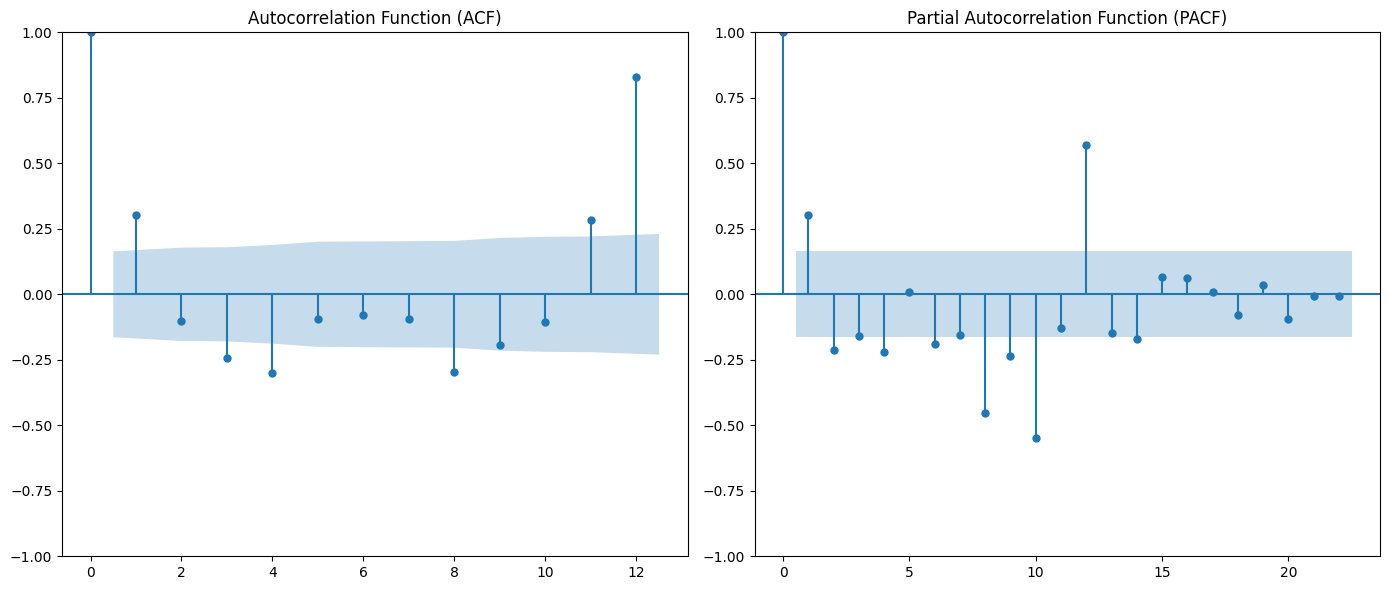

In [67]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(14, 6))

# ACF
plt.subplot(1, 2, 1)
plot_acf(data_diff, lags=12, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')

# PACF
plt.subplot(1, 2, 2)
plot_pacf(data_diff, ax=plt.gca(), method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()


In [68]:
train_df = data_diff.iloc[:-12]
test_df = data_diff.iloc[-12:]

In [69]:
size = int(len(df) - 30)
train, test = df['#Passengers'][0:size], df['#Passengers'][size:len(df)]

history = [x for x in train]
predictions = []

for t_index in test.index:

    model = sm.tsa.statespace.SARIMAX(history,order = (2,1,2),seasonal_order = (0,1,1,12))
    model_fit = model.fit()

    output = model_fit.forecast()

    yhat = output[0]
    predictions.append(float(yhat))

    obs = test[t_index]
    history.append(obs)


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


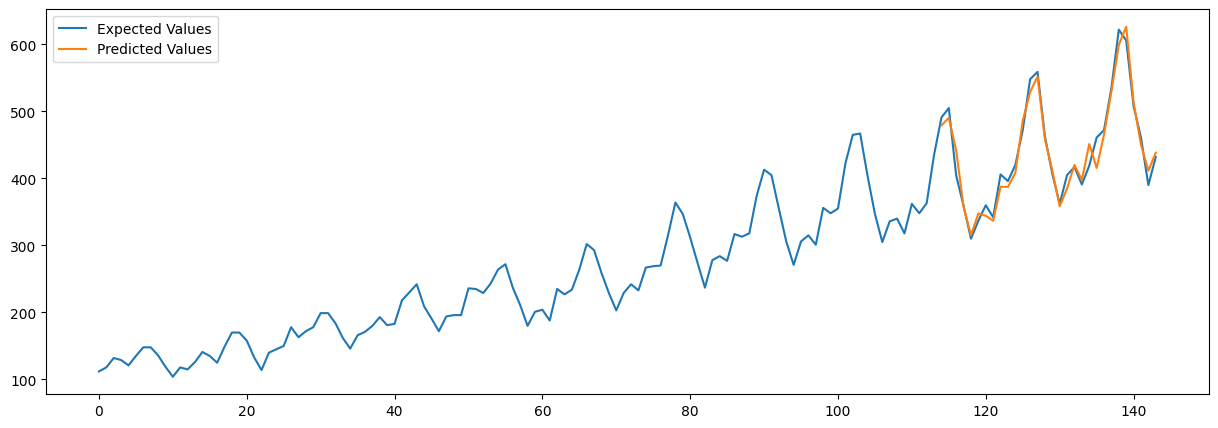

In [70]:
predictions_series = pd.Series(predictions, index = test.index)
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(df['#Passengers'],label = 'Expected Values')
plt.plot(predictions_series,label = 'Predicted Values');
plt.legend(loc="upper left")
plt.show()

In [71]:
error = np.sqrt(mean_squared_error(test,predictions))
r2 = r2_score(test, predictions)

print('Test RMSE: %.4f' % error)
print("R2 Scores", r2)


Test RMSE: 16.9252
R2 Scores 0.9521271131580658
